In [0]:

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt

In [10]:
plt.figure(figsize=(8,5))

sql_length = 20 
time_steps = np.linspace(0,np.pi, sql_length+1)
data = np.sin(time_steps)
data.resize((sql_length+1,1))

In [11]:
data

array([[0.00000000e+00],
       [1.56434465e-01],
       [3.09016994e-01],
       [4.53990500e-01],
       [5.87785252e-01],
       [7.07106781e-01],
       [8.09016994e-01],
       [8.91006524e-01],
       [9.51056516e-01],
       [9.87688341e-01],
       [1.00000000e+00],
       [9.87688341e-01],
       [9.51056516e-01],
       [8.91006524e-01],
       [8.09016994e-01],
       [7.07106781e-01],
       [5.87785252e-01],
       [4.53990500e-01],
       [3.09016994e-01],
       [1.56434465e-01],
       [1.22464680e-16]])

In [0]:
x = data[:-1]

In [16]:
x

array([[0.        ],
       [0.15643447],
       [0.30901699],
       [0.4539905 ],
       [0.58778525],
       [0.70710678],
       [0.80901699],
       [0.89100652],
       [0.95105652],
       [0.98768834],
       [1.        ],
       [0.98768834],
       [0.95105652],
       [0.89100652],
       [0.80901699],
       [0.70710678],
       [0.58778525],
       [0.4539905 ],
       [0.30901699],
       [0.15643447]])

In [0]:
y = data[1:]

In [18]:
y

array([[1.56434465e-01],
       [3.09016994e-01],
       [4.53990500e-01],
       [5.87785252e-01],
       [7.07106781e-01],
       [8.09016994e-01],
       [8.91006524e-01],
       [9.51056516e-01],
       [9.87688341e-01],
       [1.00000000e+00],
       [9.87688341e-01],
       [9.51056516e-01],
       [8.91006524e-01],
       [8.09016994e-01],
       [7.07106781e-01],
       [5.87785252e-01],
       [4.53990500e-01],
       [3.09016994e-01],
       [1.56434465e-01],
       [1.22464680e-16]])

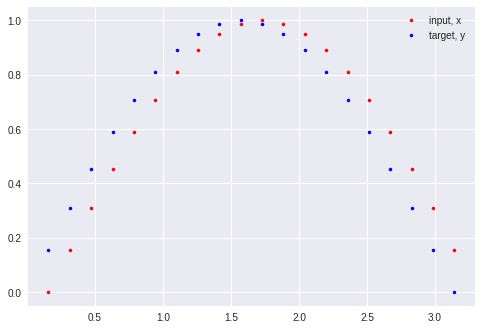

In [20]:
# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') 
plt.plot(time_steps[1:], y, 'b.', label='target, y') 

plt.legend(loc='best')
plt.show()

Define RNN

In [0]:

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden
    
  

In [24]:
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
It's typical to use an Adam optimizer for recurrent models.



In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [0]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, sql_length + 1)
        data = np.sin(time_steps)
        data.resize((sql_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.7547186017036438


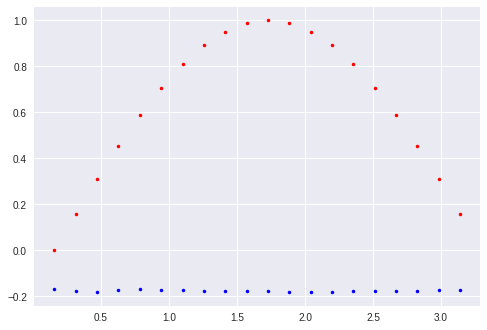

Loss:  0.007279110606759787


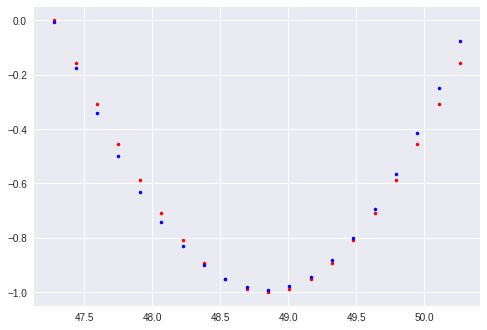

Loss:  0.000664878694806248


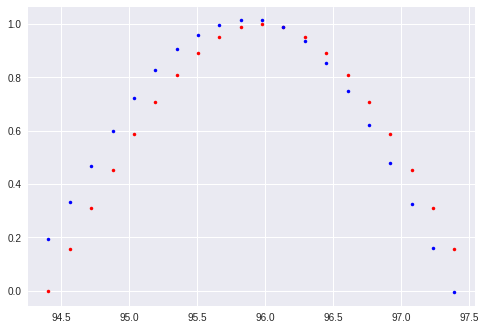

Loss:  0.0008020428358577192


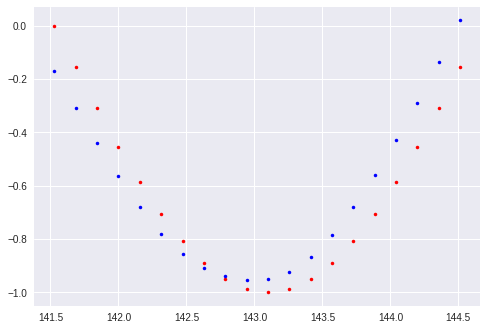

Loss:  0.0003503967309370637


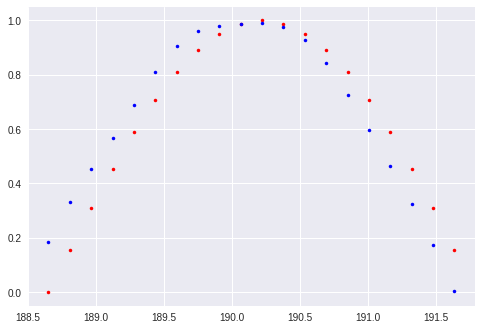

In [29]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)